# kaggle房价预测

### 1. 数据预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l

# 读取数据集
train_data = pd.read_csv('./data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('./data/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape, test_data.shape)

KeyboardInterrupt: 

In [2]:
# 获取训练集、测试集所有特征
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [3]:
# 将所有数字列调整为均值为0，方差为1
numeric_features_indexes = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features_indexes] = all_features[numeric_features_indexes].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features_indexes]=all_features[numeric_features_indexes].fillna(0)
# ***注意这里.fillna()的返回值才是填满0的，原数组不改变
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [4]:
# 将非数字列改为独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)
'''
***将bool类型转化为float类型!***
'''
all_features = 1.0*all_features 
all_features.shape

(2919, 330)

In [5]:
# 将数据转化为tensor形式以便后续处理
train_len = train_data.shape[0]
train_features = torch.tensor(all_features[:train_len].values,dtype=torch.float32)
test_features = torch.tensor(all_features[train_len:].values,dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)
print(train_features[[0,1,2]])

tensor([[ 0.0673, -0.1844, -0.2178,  0.6461, -0.5072,  1.0461,  0.8967,  0.5230,
          0.5807, -0.2930, -0.9345, -0.4442, -0.7737,  1.2072, -0.1012,  0.4135,
          1.0865, -0.2498,  0.7812,  1.2324,  0.1699, -0.2077,  0.9867, -0.9242,
          0.9731,  0.3064,  0.3488, -0.7406,  0.2000, -0.3595, -0.1033, -0.2859,
         -0.0631, -0.0896, -1.5519,  0.1576,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

### 2. 训练

首先通过线性模型进行训练

线性模型：

+ 提供健全性检查（查看数据中是否存在有意义的信息）

+ 作为基线(baseline)模型，直观地知道最好的模型比简单的模型好多少

In [6]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
lr = 0.04
weight_decay = 20

net = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(),nn.Linear(512,512),nn.ReLU(),nn.Linear(512,1))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_weights)


optimizer = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)

对于房价我们关心相对误差$(y-\hat{y})/y$，而不是绝对误差$y-\hat{y}$

用价格预测的对数来估计差异：$|log {y}-log \hat{y}|$

这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：$ \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(logy_i-log\hat{y_i})}} $

In [7]:
# 均方根误差，返回的直接是python的值，用于评估模型的准确率
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features),1,float('inf')) # 将所有y_hat值约束到1和正无穷之间
    rmse = torch.sqrt(loss(torch.log(clipped_preds), 
                           torch.log(labels))) # 均方根误差
    return rmse.item()

log_rmse(net, train_features, train_labels)

12.030679702758789

In [8]:
# 训练
def load_array(data_arrays, batch_size, is_train = True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, batch_size):
    train_ls = []
    test_ls = []
    train_iter = load_array((train_features,train_labels), batch_size, is_train=True)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### 3. K折交叉验证

In [9]:
# 获取k折的数据
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    X_valid, y_valid = None, None
    for j in range(0,k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part = X[idx,:]
        y_part = y[idx]
        if j==i:
            X_valid = X_part
            y_valid = y_part
        elif X_train is None:
            X_train = X_part
            y_train = y_part
        else:
            X_train = torch.cat((X_train,X_part),0)
            y_train = torch.cat((y_train,y_part),0)
    return X_train, y_train, X_valid, y_valid

In [10]:
def k_fold(k, X_train, y_train, num_epochs, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        train_ls, valid_ls = train(net, *data,num_epochs=num_epochs,batch_size=batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],
                     xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                     legend=['train','valid'],yscale='log')
        print(f'折{i+1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.023420, 验证log rmse0.136626
折2，训练log rmse0.020510, 验证log rmse0.050230
折3，训练log rmse0.027817, 验证log rmse0.051463
折4，训练log rmse0.015381, 验证log rmse0.053860
折5，训练log rmse0.020614, 验证log rmse0.052646
折6，训练log rmse0.005556, 验证log rmse0.023619
折7，训练log rmse0.005942, 验证log rmse0.026852
折8，训练log rmse0.021118, 验证log rmse0.032931
折9，训练log rmse0.010826, 验证log rmse0.026218
折10，训练log rmse0.004117, 验证log rmse0.025915


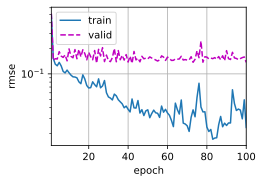

In [11]:
k = 10
num_epochs = 100
batch_size = 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, batch_size)

### 4. 预测

In [12]:
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
submission = pd.concat((test_data['Id'],test_data['SalePrice']),axis=1)
submission.to_csv('./data/house-prices-advanced-regression-techniques/submission.csv',index=False)

## 提交记录

2024.9.24 若干次提交，未记录细节，大致探索过程：

1. 单层线性模型 -> 双层MLP -> 三层MLP，loss逐渐减少了

2. lr调到0.04，0.05是比较好的

3. num_epochs调到100比少次数更好了，调到200反而变差

4. k折调到10效果还不错，变大变小似乎都会变差

5. batch_size一直是64没动

6. weight_decay调到20了，效果不错，再调大(30)似乎会变差

9.24 最后一次提交参数：

num_epochs=100

lr=0.04

weight_decay=20

batch_size=64

k=10

模型为nn.Sequential(nn.Linear(in_features, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 1))

最终第10折训练log rmse = 0.004117，验证log rmse =0.025915